# Transfer Learning with Tensorflow part 2 : Fine tuning

In [1]:
# Check if we're using a GPU
!nvidia-smi

Sat Jan 28 15:46:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    30W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!wget https://raw.githubusercontent.com/maulairfani/DataScience-Learning-Notebooks/main/helper_functions.py

--2023-01-28 15:46:38--  https://raw.githubusercontent.com/maulairfani/DataScience-Learning-Notebooks/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-28 15:46:39 (117 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

link : https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [4]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2023-01-28 15:46:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.4MB/s    in 8.2s    

2023-01-28 15:46:51 (19.6 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [6]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [7]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical",
                                                                           batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
for images, labels in train_data_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[1.34181442e+02 1.38641266e+02 1.17267860e+02]
   [1.30512756e+02 1.31802292e+02 8.65341187e+01]
   [1.38933990e+02 1.36460785e+02 6.00714264e+01]
   ...
   [2.47169678e+02 2.53000000e+02 2.42660645e+02]
   [2.47647308e+02 2.52549103e+02 2.40352692e+02]
   [2.45183014e+02 2.52816986e+02 2.42000000e+02]]

  [[1.31487244e+02 1.42495529e+02 1.15821426e+02]
   [1.29403702e+02 1.32397324e+02 7.81721954e+01]
   [1.42778702e+02 1.33738205e+02 5.05446396e+01]
   ...
   [2.46254517e+02 2.52006058e+02 2.41903046e+02]
   [2.47647308e+02 2.52039215e+02 2.41372452e+02]
   [2.45183014e+02 2.52816986e+02 2.42000000e+02]]

  [[1.26205353e+02 1.44505417e+02 1.27575890e+02]
   [1.30611603e+02 1.37663589e+02 8.97630768e+01]
   [1.49102997e+02 1.38175385e+02 5.76042709e+01]
   ...
   [2.46084839e+02 2.51169678e+02 2.43915161e+02]
   [2.46549103e+02 2.52098206e+02 2.43450897e+02]
   [2.45183014e+02 2.51816986e+02 2.44000000e+02]]

  ...

  [[1.96867249e+02 1.71867249e+02 7.90815048e+01]
   [1

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

it gives us more flexibel with our models

In [11]:
# 1. Create the base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the basee model
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after passing inputs through base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the modt important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine th einputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model
history_model_0 = model_0.fit(train_data_10_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data_10_percent,
                              validation_steps=int(len(test_data_10_percent)*.25),
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="10_percent_feature_extraction")])

16705208/16705208 [==============================] - 2s 0us/step
Shape after passing inputs through base_model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230128-154703
Epoch 1/5
24/24 [==============================] - 18s 256ms/step - loss: 1.8720 - accuracy: 0.4373 - val_loss: 1.2709 - val_accuracy: 0.7681
Epoch 2/5
24/24 [==============================] - 5s 185ms/step - loss: 1.0872 - accuracy: 0.7733 - val_loss: 0.8496 - val_accuracy: 0.8355
Epoch 3/5
24/24 [==============================] - 5s 183ms/step - loss: 0.7797 - accuracy: 0.8267 - val_loss: 0.6807 - val_accuracy: 0.8586
Epoch 4/5
24/24 [==============================] - 5s 183ms/step - loss: 0.6355 - accuracy: 0.8560 - val_loss: 0.6112 - val_accuracy: 0.8618
Epoch 5/5
24/24 [==============================] - 5s 182ms/step - loss: 0.5406 - accuracy: 0.8827 - val_loss: 0.5414 - val_accuracy: 0.8816


In [12]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 tf.math.truediv
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [13]:
# How about we get a summary of the base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [14]:
# How about a summary of our whole model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


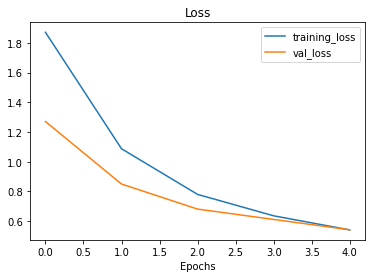

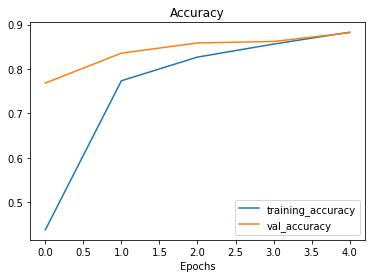

In [15]:
# Check out our model's training curves
plot_loss_curves(history_model_0)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D Layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280)

But then when it passes through GlobalAveragePooling2D layer, it turns into (None, 1280)

Let's use a similar shaped tensor of (1, 4, 4, 3)

In [16]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooled 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of 2 different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [17]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a series of transfer learning experiments

we'll go with 1% data instead of 10%

1. `model_1` - use feature extraction transfer learning with 1% of training data with data augmentation
2. `model_2` - use feature extraction with 10% of training with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` -  use fine-tuning transfer learning on 100% of the training data with data augmentation

### Getting and preprocessing data for model_1

In [18]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data("10_food_classes_1_percent.zip")

--2023-01-28 15:47:52--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  24.0MB/s    in 6.4s    

2023-01-28 15:47:59 (19.9 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [19]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test"

# How many images are we working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There a

In [20]:
# Setup data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32,
                                                                           image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=32)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

* `tf.keras.layers.experimental.preprocessing()`

the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) happends on the GPU
* Image data augmentation only happens during training, so we can still export our whole model an duse it elsewhere (bisa sekalian di save)

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1./255) 
], name="data_augmentation")

 ### Visualize our data augmentation layer (and see what happens to our data)

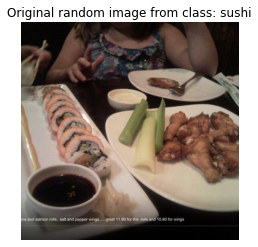

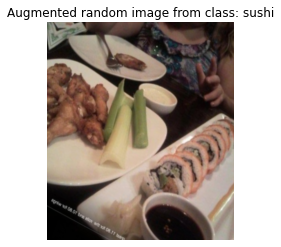

In [22]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read and plot in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0), training=True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [23]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Adding data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(.25 * len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230128-154803
Epoch 1/5
3/3 [==============================] - 11s 2s/step - loss: 2.4402 - accuracy: 0.1143 - val_loss: 2.2168 - val_accuracy: 0.1990
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1540 - accuracy: 0.3143 - val_loss: 2.0723 - val_accuracy: 0.2993
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.9726 - accuracy: 0.4000 - val_loss: 1.9515 - val_accuracy: 0.4095
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.7941 - accuracy: 0.5143 - val_loss: 1.8399 - val_accuracy: 0.4556
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6393 - accuracy: 0.5857 - val_loss: 1.7584 - val_accuracy: 0.4868


In [24]:
# Check out a model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [25]:
# Evaluate on the fill test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 6s 75ms/step - loss: 1.7755 - accuracy: 0.4740


[1.7755390405654907, 0.4740000069141388]

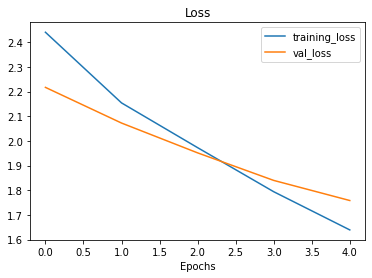

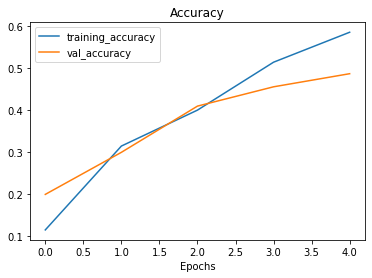

In [26]:
plot_loss_curves(history_1_percent)

## Model 2: Feature Extraction Transfer Learning on 10% of data with data augmenatation

In [27]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Adding data augmentation Sequential model as a layer
x = data_augmentation(inputs, training=False)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax")(x)

# Make a model using the inputs and outputs
model_2 = keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_model_2 = model_2.fit(train_data_10_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data,
                              validation_steps=int(0.25 * len(test_data)),
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="10_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230128-154841
Epoch 1/5
24/24 [==============================] - 11s 241ms/step - loss: 1.8376 - accuracy: 0.4400 - val_loss: 1.2711 - val_accuracy: 0.7286
Epoch 2/5
24/24 [==============================] - 5s 185ms/step - loss: 1.0319 - accuracy: 0.8013 - val_loss: 0.8394 - val_accuracy: 0.8207
Epoch 3/5
24/24 [==============================] - 4s 148ms/step - loss: 0.7373 - accuracy: 0.8440 - val_loss: 0.7113 - val_accuracy: 0.8191
Epoch 4/5
24/24 [==============================] - 4s 151ms/step - loss: 0.5908 - accuracy: 0.8760 - val_loss: 0.6256 - val_accuracy: 0.8470
Epoch 5/5
24/24 [==============================] - 5s 183ms/step - loss: 0.5004 - accuracy: 0.9000 - val_loss: 0.5630 - val_accuracy: 0.8618


In [28]:
# Evaluate on the fill test dataset
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 71ms/step - loss: 0.5518 - accuracy: 0.8628


[0.551820695400238, 0.8628000020980835]

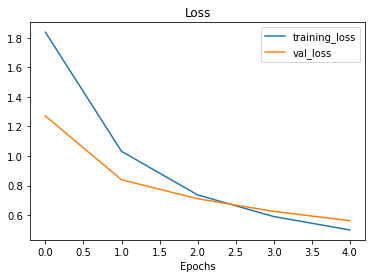

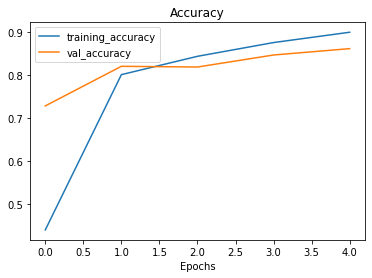

In [29]:
plot_loss_curves(history_model_2)

In [30]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

### Create Model Checkpointing callback

In [31]:
# Set Checkpoint path
checkpoint_path = "ten_percent_model_checkpoint_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        weights_only=True,
                                                        save_best_only=False,
                                                        save_freq="epoch",
                                                        verbose=1)

### Fit model 2 passing in the ModelCheckpoint Callback

In [32]:
# Fit the model using checkpoint callback
initial_epochs=5
history_model_2 = model_2.fit(train_data_10_percent,
                              epochs=initial_epochs,
#                               steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data,
                              validation_steps=int(len(test_data) * 0.25),
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="10_percent_data_aug"),
                                        checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230128-154925
Epoch 1/5
23/24 [===========================>..] - ETA: 0s - loss: 0.4343 - accuracy: 0.9130
Epoch 1: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt


24/24 [==============================] - 40s 2s/step - loss: 0.4349 - accuracy: 0.9133 - val_loss: 0.5430 - val_accuracy: 0.8520
Epoch 2/5
23/24 [===========================>..] - ETA: 0s - loss: 0.3784 - accuracy: 0.9321
Epoch 2: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt


24/24 [==============================] - 39s 2s/step - loss: 0.3857 - accuracy: 0.9280 - val_loss: 0.5022 - val_accuracy: 0.8602
Epoch 3/5
23/24 [===========================>..] - ETA: 0s - loss: 0.3410 - accuracy: 0.9375
Epoch 3: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt


24/24 [==============================] - 41s 2s/step - loss: 0.3428 - accuracy: 0.9373 - val_loss: 0.4894 - val_accuracy: 0.8684
Epoch 4/5
23/24 [===========================>..] - ETA: 0s - loss: 0.3041 - accuracy: 0.9524
Epoch 4: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt


24/24 [==============================] - 40s 2s/step - loss: 0.3079 - accuracy: 0.9493 - val_loss: 0.4778 - val_accuracy: 0.8586
Epoch 5/5
23/24 [===========================>..] - ETA: 0s - loss: 0.2798 - accuracy: 0.9579
Epoch 5: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt


24/24 [==============================] - 41s 2s/step - loss: 0.2788 - accuracy: 0.9587 - val_loss: 0.4756 - val_accuracy: 0.8586


In [33]:
# What were model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.5477 - accuracy: 0.8668


[0.5477158427238464, 0.8668000102043152]

In [34]:
# Check model_2 results on all test_data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 71ms/step - loss: 0.4426 - accuracy: 0.8760


[0.4426363706588745, 0.8759999871253967]

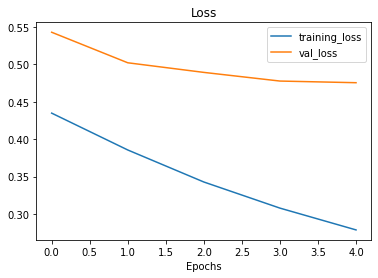

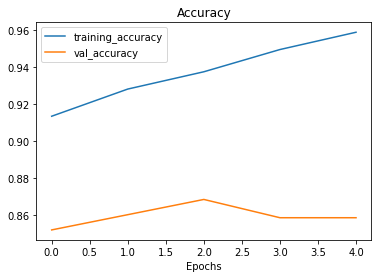

In [35]:
# Plot model loss curves
plot_loss_curves(history_model_2)

### Loading in checkpointed weights

In [36]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [37]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 70ms/step - loss: 0.4426 - accuracy: 0.8760


In [38]:
# If the results from our previously evaluated model_2 match the loaded weights, everything has worked!
results_10_percent_data_aug == loaded_weights_model_results

False

In [39]:
# Check to see if loaded model results are very close to our previous non_loaded model_2
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [40]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[2.98023224e-08 0.00000000e+00]


## Model 3: Fine-tuning an existing model on 10% of the data

✏️**Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data

In [41]:
# Layers in loaded model
model_2.layers

In [42]:
# Are these layers trainable?
for layer in model_2.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fcb843b9190> True
<keras.engine.sequential.Sequential object at 0x7fcb8b986070> True
<keras.engine.functional.Functional object at 0x7fcb84083fa0> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fcb843b9040> True
<keras.layers.core.dense.Dense object at 0x7fcb843b9340> True


In [43]:
# What layers are in our base_model and are they trainables?
for i, layer in enumerate(model_2.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [44]:
# How many trainable variables are in our base model
print(len(model_2.layers[2].trainable_variables))

0


In [45]:
for layer in model_2.layers[2].layers[-10:]:
    layer.trainable = True

In [46]:
# To begin fine-tuning let's start by setting the last 10 layers of our base-model
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
    layer.trainable=False

# for layer in base_model.layers[-10:]:
#     print(layer.name, layer.trainable)
    
# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               metrics=["accuracy"])

✏️ **Note:** Biasanya, saat fine-tuning sebuah model, kita menggunakan nilai learning rate yang lebih kecil dari defaultnya, berapa? biasanya minimal 1/10 dari default. Tapi berbagai sumber bisa bilang beda"

In [47]:
# How many trainable variables are in our base model after we unfrozen the last 10 layers
print(len(model_2.layers[2].trainable_variables))

10


In [48]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                              epochs=fine_tune_epochs,
                                              validation_data=test_data,
                                              validation_steps=int(len(test_data)*0.25),
                                              initial_epoch=history_model_2.epoch[-1],
                                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                    experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230128-155357
Epoch 5/10
24/24 [==============================] - 12s 246ms/step - loss: 0.2308 - accuracy: 0.9533 - val_loss: 0.4010 - val_accuracy: 0.8684
Epoch 6/10
24/24 [==============================] - 5s 187ms/step - loss: 0.1451 - accuracy: 0.9760 - val_loss: 0.3904 - val_accuracy: 0.8684
Epoch 7/10
24/24 [==============================] - 4s 151ms/step - loss: 0.1055 - accuracy: 0.9813 - val_loss: 0.3446 - val_accuracy: 0.8668
Epoch 8/10
24/24 [==============================] - 5s 185ms/step - loss: 0.0789 - accuracy: 0.9893 - val_loss: 0.3931 - val_accuracy: 0.8668
Epoch 9/10
24/24 [==============================] - 4s 151ms/step - loss: 0.0595 - accuracy: 0.9947 - val_loss: 0.4007 - val_accuracy: 0.8536
Epoch 10/10
24/24 [==============================] - 5s 186ms/step - loss: 0.0440 - accuracy: 0.9987 - val_loss: 0.4206 - val_accuracy: 0.8569


In [49]:
# Evaluate the fine-tuned model
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.3735 - accuracy: 0.8764


In [50]:
results_fine_tune_10_percent

[0.37346526980400085, 0.8763999938964844]

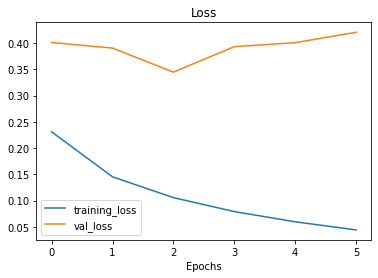

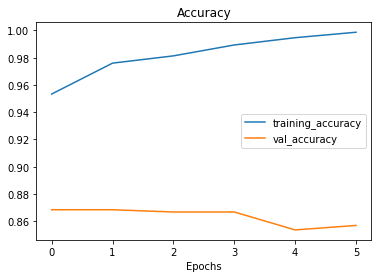

In [51]:
plot_loss_curves(history_fine_10_percent_data_aug)

In [52]:
# Let's create a function 
def compare_history(original_history, new_history, initial_epochs):
    """
    Compares two TensorFlow History objects
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]
    
    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]
    
    # Combine original history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]
    
    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]
    
    # Make plots for accuracy
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label="Training Accuracy")
    plt.plot(total_val_acc, label="Validation Accuracy")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")
    
    # Make plots for accuracy
#     plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label="Training Loss")
    plt.plot(total_val_loss, label="Validation Loss")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")

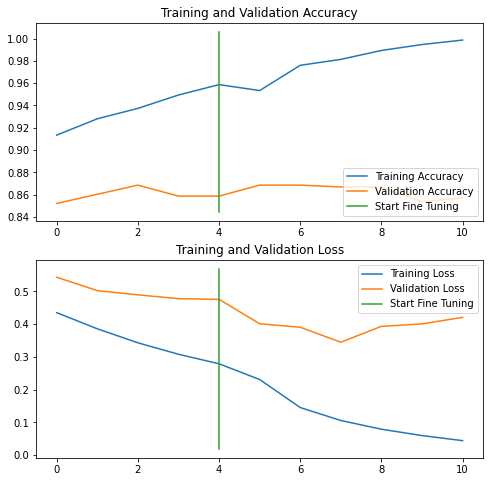

In [53]:
compare_history(history_model_2,
               history_fine_10_percent_data_aug,
               initial_epochs=5)

## Model 4: Fine-tuning and existing model on all of the data

In [54]:
# Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2023-01-28 15:54:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 172.217.194.128, 172.253.118.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  24.3MB/s    in 22s     

2023-01-28 15:55:07 (22.3 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [55]:
# Setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [56]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.

In [57]:
# Setup data input
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode="categorical",
                                                               image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previous experiments (all experiments have used the same test dataset)

Let's verify this..

In [58]:
# Evaluate model 2 (this is the fine-tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.3735 - accuracy: 0.8764


[0.37346532940864563, 0.8763999938964844]

In [59]:
results_fine_tune_10_percent

[0.37346526980400085, 0.8763999938964844]

To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights. 

In [60]:
# Load weights from checkpoint, that way we can fine-tune from 
# the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path)

In [61]:
# Let's evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.4426 - accuracy: 0.8760


[0.4426364600658417, 0.8759999871253967]

In [62]:
# Check to see if our model_2 has beed reverted back to feature extraction results
results_10_percent_data_aug

[0.4426363706588745, 0.8759999871253967]

Alright, the previous steps might seem quite confusing, but all we've done is:
1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the model's weights using `ModelCheckpoint` callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3)
3. Saved the results and training logs each time
4. Reloaded the model from step 1 to do the same steps as step 2 except this time we're going to use all of the data (model_4)

In [63]:
# Check which layers ar tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 dense True


In [64]:
# Let's drill into our base_model (efficientNetB0) and see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [65]:
# Compile
model_2.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # JANGAN LUPA
               metrics=["accuracy"])

In [66]:
# Continue to train and fine-tune the model to our data (100% of training data)
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                          epochs=fine_tune_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(len(test_data) * .25),
                                          initial_epoch = history_model_2.epoch[-1],
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20230128-155534
Epoch 5/10
235/235 [==============================] - 27s 92ms/step - loss: 0.4460 - accuracy: 0.8568 - val_loss: 0.3065 - val_accuracy: 0.8997
Epoch 6/10
235/235 [==============================] - 20s 83ms/step - loss: 0.3294 - accuracy: 0.8965 - val_loss: 0.2832 - val_accuracy: 0.9079
Epoch 7/10
235/235 [==============================] - 20s 84ms/step - loss: 0.2631 - accuracy: 0.9181 - val_loss: 0.2725 - val_accuracy: 0.9178
Epoch 8/10
235/235 [==============================] - 20s 83ms/step - loss: 0.2099 - accuracy: 0.9397 - val_loss: 0.2777 - val_accuracy: 0.9309
Epoch 9/10
235/235 [==============================] - 20s 83ms/step - loss: 0.1726 - accuracy: 0.9504 - val_loss: 0.2658 - val_accuracy: 0.9276
Epoch 10/10
235/235 [==============================] - 20s 84ms/step - loss: 0.1384 - accuracy: 0.9641 - val_loss: 0.2754 - val_accuracy: 0.9276


In [67]:
# Let's evaluate on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data)

79/79 [==============================] - 6s 70ms/step - loss: 0.2511 - accuracy: 0.9252


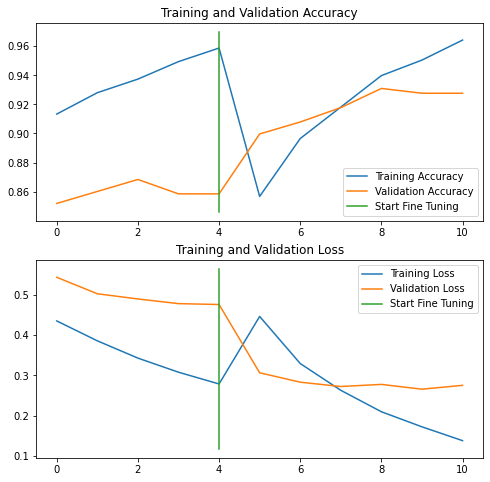

In [68]:
# How did fine-tuning go with more data?
compare_history(original_history=history_model_2,
               new_history=history_fine_10_classes_full,
               initial_epochs=5)

## Viewing our experiment data on TensorBoard

✏️ **Note** : Anything you upload to TensorBoard.dev is going to be public. So if you have private data, do not upload

In [69]:
# View tensorboard logs of transfer learning modelling experiment (should ~ 4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
    --name "Transfer Learning Experiments with 10 Food101 Classes" \
    --description "A series of different transfer learning experiments with varying amount of data and fine-tuning" \
    --one_shot # exits the uploader once its finished


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=LGfOOaxemIVohy5yoMm2cMaKh2qZbd&prompt=consent&access_type=o